# Sample Notebook - Tokenizer

We will use the [CyNER dataset](https://github.com/aiforsec/CyNER/tree/main/dataset/mitre)

CyNER is a method for automatically structuring CTIs and converting them into STIX format, presented in:

- [CyNER: Information Extraction from Unstructured Text of CTI Sources with Noncontextual IOCs](https://dl.acm.org/doi/abs/10.1007/978-3-031-15255-9_5).

### Load dataset

In [1]:
import pandas as pd
INPUT_PATH = "CyNER_dataset/train.parquet"
train_df = pd.read_parquet(INPUT_PATH)
print(f"The dataset contains {train_df.shape[0]:,} elements")
train_df.head(2)

The dataset contains 3,690 elements


,sentences,tags
0,The precautions you take online have been cove...,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
1,This brand new malware has real potential to b...,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."


#### Each entry represents a CTI, and it's coupled with the extracted cybersecurity tags

In [2]:
EXAMPLE_ID = 2
print("Example:")
print(f"\t- CTI sentence: {train_df.iloc[EXAMPLE_ID]['sentences']}")
print(f"\t- Extracted tags: {train_df.iloc[EXAMPLE_ID]['tags']}")

Example:
	- CTI sentence: Recommendations Popular mobile platforms like Android are common targets for organized or commercialized monitoring operations .
	- Extracted tags: ['O' 'O' 'O' 'O' 'O' 'B-System' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O']


#### Which are the possible tags?

In [3]:
train_df.tags.explode().unique()

array(['O', 'B-System', 'B-Indicator', 'I-Indicator', 'B-Malware',
       'B-Organization', 'I-Organization', 'I-System', 'B-Vulnerability',
       'I-Vulnerability', 'I-Malware'], dtype=object)

**Which stands for:**
- System = software, hardware systems
- Indicator = IOCs (Indicators of Compromise)
- Malware = malware names
- Organization = company/teams
- Vulnerability = known vulnerabilities

**While:**
- B = Beginning
- I = Inside
- O = Outside

**For instance:**

"The malware TrickBot and Emotet were detected" --> \[(The, O), (malware, O), (TrickBot, B-Malware), (and, O), (Emotet, B-Malware), (were, O), (detected,O)\]

"The malware Remote Access Trojan was installed." --> \[(The, O), (malware, O), (Remote, B-Malware), (Access, I-Malware), (Trojan, I-Malware), (was, O), (installed,O)\]

### Let's load a Tokenizer!

In [4]:
from transformers import AutoTokenizer

#### Each tokenizer is coupled with a model 
- In order to load a tokenizer, we need to choose which model we will use!

In [5]:
model = "google-bert/bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model)

#### As we mentioned, each tokenizer "comes" with a vocabulary

In [6]:
print(f"The model '{model}' has a vocabulary size of {tokenizer.vocab_size:,} tokens")

The model 'google-bert/bert-base-uncased' has a vocabulary size of 30,522 tokens


#### Let's see some examples!
##### The models uses some special tokens

In [7]:
tokenizer.special_tokens_map

{'unk_token': '[UNK]',
 'sep_token': '[SEP]',
 'pad_token': '[PAD]',
 'cls_token': '[CLS]',
 'mask_token': '[MASK]'}

##### Each token is assigned an input_IDS 

In [8]:
for value in tokenizer.special_tokens_map.values():
    print(f"Special token '{value}' has input_ids {tokenizer.vocab[value]}")

Special token '[UNK]' has input_ids 100
Special token '[SEP]' has input_ids 102
Special token '[PAD]' has input_ids 0
Special token '[CLS]' has input_ids 101
Special token '[MASK]' has input_ids 103


#### Some other "random" examples:

In [9]:
for key in list(tokenizer.vocab.keys())[30:40]:
    print(f"Token '{key}' has input_ids {tokenizer.vocab[key]}")

Token '##mology' has input_ids 20570
Token 'websites' has input_ids 11744
Token 'rapidly' has input_ids 5901
Token 'fur' has input_ids 6519
Token '1794' has input_ids 13199
Token '##rano' has input_ids 20770
Token '1713' has input_ids 27016
Token 'piazza' has input_ids 22463
Token '##ス' has input_ids 30233
Token 'rallies' has input_ids 22867


#### How do we tokenize a sentence? Just "call" the tokenizer!

In [10]:
SAMPLE_SENTENCE = 1
sample_sentence = train_df["sentences"].iloc[SAMPLE_SENTENCE]
tokenized_sentence = tokenizer(sample_sentence)
tokenized_sentence

{'input_ids': [101, 2023, 4435, 2047, 15451, 8059, 2038, 2613, 4022, 2000, 2468, 1996, 2279, 2502, 4684, 15451, 8059, 1010, 2004, 2009, 2003, 2104, 5377, 2009, 25284, 8377, 1010, 21078, 1037, 4187, 4082, 2291, 3444, 1010, 1998, 7889, 3361, 5097, 1012, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

#### Notice that we produced:
- "input_ids": The original sentence was split into tokens, and each token was replaced with its input_ids.
- "attention_mask": Mask that tells the encoder whether the other tokens shall "pay" attention to the given token.

### How was the sentence split into tokens?

In [11]:
# Extract the input_ids
input_ids = tokenized_sentence["input_ids"]
# Convert the input_ids into the corresponding tokens
tokens = tokenizer.convert_ids_to_tokens(input_ids)
print(f"Original sentence (contained {len(sample_sentence.split())} words):\n{sample_sentence}")
print(f"\nTokenized sentence (contains {len(tokens)} tokens):\n{tokens}")

Original sentence (contained 35 words):
This brand new malware has real potential to become the next big mobile malware , as it is under constant iterative improvements , abuses a critical operating system feature , and targets financial applications .

Tokenized sentence (contains 40 tokens):
['[CLS]', 'this', 'brand', 'new', 'mal', '##ware', 'has', 'real', 'potential', 'to', 'become', 'the', 'next', 'big', 'mobile', 'mal', '##ware', ',', 'as', 'it', 'is', 'under', 'constant', 'it', '##erative', 'improvements', ',', 'abuses', 'a', 'critical', 'operating', 'system', 'feature', ',', 'and', 'targets', 'financial', 'applications', '.', '[SEP]']


### Tokenize an entire dataset
#### The tokenizer can get as input a single string (like above) or a list of strings!

In [12]:
full_list_sentences = train_df["sentences"].tolist()
tokenized_sentences = tokenizer(full_list_sentences)

Token indices sequence length is longer than the specified maximum sequence length for this model (564 > 512). Running this sequence through the model will result in indexing errors


#### We succesfully tokenized the entire list of sentences! 
However, as reported in the warning, some of the sentences produced more tokens than what the chosen model ("bert-base") can process!

In [13]:
print(f"The context size (i.e., max number of tokens) of the model is: {tokenizer.model_max_length:,}")

The context size (i.e., max number of tokens) of the model is: 512


#### Let's plot the current distribution:

In [14]:
from collections import Counter
import numpy as np
def get_ecdf(list_numbers):
    counter = Counter(list_numbers)
    values = sorted(counter.keys())
    counts = [counter[value] for value in values]
    # Step 2: Calculate the CDF
    total = sum(counts)
    cumulative_probs = np.cumsum(counts) / total
    return values, cumulative_probs

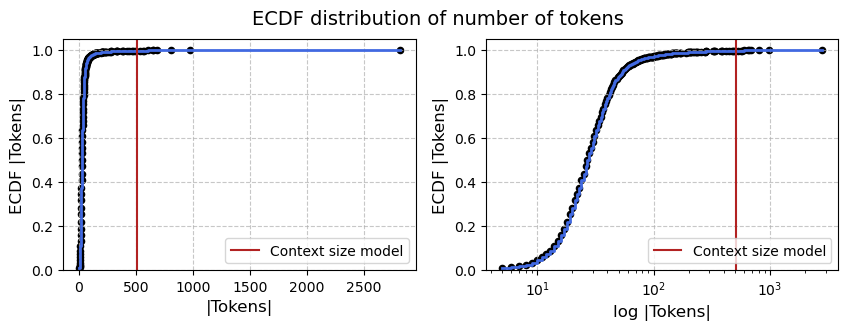

In [15]:
import matplotlib.pyplot as plt
n_tokens_x_sentence = [len(el) for el in tokenized_sentences["input_ids"]]
n_tokens, cumularive_n_tokens = get_ecdf(n_tokens_x_sentence)

fig, axs = plt.subplots(1, 2, figsize=(10, 3))
for ax in axs:
    ax.step(n_tokens, cumularive_n_tokens, where='post', color='royalblue', linewidth=2)
    ax.scatter(n_tokens, cumularive_n_tokens, color='black', s=20)
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.set_ylabel('ECDF |Tokens|', fontsize=12)
    ax.set_ylim(0, 1.05)
    ax.axvline(512, 0, 1.05, c="firebrick", label = f"Context size model")
    ax.legend()

fig.suptitle('ECDF distribution of number of tokens', fontsize=14)
axs[0].set_xlabel('|Tokens|', fontsize=12)
axs[1].set_xlabel('log |Tokens|', fontsize=12)
axs[1].set_xscale("log")
plt.show()

### To prevent future errors from the model, a simple solution is to truncate long inputs!

In [16]:
truncated_tokenized_sentences = tokenizer(full_list_sentences, truncation=True)
n_truncated_tokens = [len(el) for el in truncated_tokenized_sentences["input_ids"]]

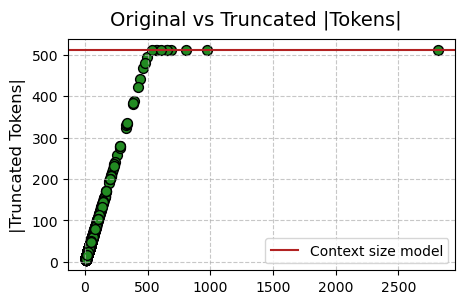

In [26]:
fig, ax = plt.subplots(1, figsize=(5, 3))
ax.scatter(n_tokens_x_sentence, n_truncated_tokens, s=50, 
           color="forestgreen", edgecolor="k", linewidth=1)
ax.axhline(512, c="firebrick", label = f"Context size model")
ax.grid(True, linestyle='--', alpha=0.7)
ax.set_ylabel('|Original Tokens|', fontsize=12)
ax.set_ylabel('|Truncated Tokens|', fontsize=12)
ax.legend()
fig.suptitle('Original vs Truncated |Tokens|', fontsize=14)
plt.show()

### Notice: sometimes we must keep track of how each work is split into tokens (e.g., FakeSpy > \[Fake, Sp, y\])
#### It is the case for instance when facing the task of Named Entity Recognition (NER) - See later

#### For those cases, we need to slightly change the pipeline!

In [33]:
# 1. Instead of feeding the sentence as a string, we previously split it
split_sample_sentence = train_df["sentences"].iloc[SAMPLE_SENTENCE].split()
print(split_sample_sentence)

['This', 'brand', 'new', 'malware', 'has', 'real', 'potential', 'to', 'become', 'the', 'next', 'big', 'mobile', 'malware', ',', 'as', 'it', 'is', 'under', 'constant', 'iterative', 'improvements', ',', 'abuses', 'a', 'critical', 'operating', 'system', 'feature', ',', 'and', 'targets', 'financial', 'applications', '.']


In [35]:
# 2. When loading the tokenizer, specify that it will tackle sentences that have already been processed
tokenizer = AutoTokenizer.from_pretrained(model, add_prefix_space=True)

In [38]:
# 3. When calling the tokenizer, specify `is_split_into_words=True`
tokenized_sentence = tokenizer(split_sample_sentence, is_split_into_words=True)

#### Now, we can know to which word each tokens belong to!

In [43]:
# Extract the "word_ids" from the tokenized input
print(f"In the original sentence there were {len(split_sample_sentence)} words")
word_ids = tokenized_sentence.word_ids()
print(f"With word_ids, we can know how the {len(tokenized_sentence['input_ids'])} tokens relate to the original words.")
print(f"Particularly, the mapping for each token is: {word_ids}")

In the original sentence there were 35 words
With word_ids, we can know how the 40 tokens relate to the original words.
Particularly, the mapping for each token is: [None, 0, 1, 2, 3, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 13, 14, 15, 16, 17, 18, 19, 20, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, None]


In [45]:
print(f"In practise: Given the sentence: '{sample_sentence}'")
for word_id, input_id in zip(word_ids, tokenized_sentence["input_ids"]):
    if word_id is not None: # One associated to <CLS> or <EOS>
        token = tokenizer.convert_ids_to_tokens(input_id)
        print(f"\t - Token {token} belongs to word {word_id} ({split_sample_sentence[word_id]})")

In practise: Given the sentence: 'This simulation shows that FakeSpy behaves differently on a physical device versus an emulator .'
	 - Token this belongs to word 0 (This)
	 - Token brand belongs to word 1 (brand)
	 - Token new belongs to word 2 (new)
	 - Token mal belongs to word 3 (malware)
	 - Token ##ware belongs to word 3 (malware)
	 - Token has belongs to word 4 (has)
	 - Token real belongs to word 5 (real)
	 - Token potential belongs to word 6 (potential)
	 - Token to belongs to word 7 (to)
	 - Token become belongs to word 8 (become)
	 - Token the belongs to word 9 (the)
	 - Token next belongs to word 10 (next)
	 - Token big belongs to word 11 (big)
	 - Token mobile belongs to word 12 (mobile)
	 - Token mal belongs to word 13 (malware)
	 - Token ##ware belongs to word 13 (malware)
	 - Token , belongs to word 14 (,)
	 - Token as belongs to word 15 (as)
	 - Token it belongs to word 16 (it)
	 - Token is belongs to word 17 (is)
	 - Token under belongs to word 18 (under)
	 - Token co

### For more details about the tokenizer class, please refer to:
- https://huggingface.co/docs/transformers/en/main_classes/tokenizer